In [1]:
import os
import glob
import pandas as pd

# 6score 的根目錄
root_dir = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score"

# 轉換 中文類別 → 整數 label
label_map = {
    "正常": 0,
    "異常": 1,
    "故障": 2,
}

rows = []

# 走過每一個 turnout 資料夾：P1602N, P1602R, ...
for device_name in os.listdir(root_dir):
    device_path = os.path.join(root_dir, device_name)
    if not os.path.isdir(device_path):
        continue

    # 走過三個子資料夾：正常 / 異常 / 故障
    for class_name in ["正常", "異常", "故障"]:
        class_folder = os.path.join(device_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        csv_paths = glob.glob(os.path.join(class_folder, "*.csv"))
        for path in csv_paths:
            rows.append({
                "file_path": path,
                "device": device_name,     # P1602N / P1602R / ...
                "class_name": class_name,  # 正常 / 異常 / 故障
                "label_idx": label_map[class_name],
            })

manifest = pd.DataFrame(rows)
print("總樣本數：", len(manifest))
display(manifest.head())

print("\n整體類別分布：")
print(manifest["class_name"].value_counts())


總樣本數： 4372


,file_path,device,class_name,label_idx
0,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
1,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
2,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
3,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
4,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0



整體類別分布：
class_name
正常    3222
異常    1028
故障     122
Name: count, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split

# 先做 manifest（跟之前一樣）
# manifest 需要有 device 和 class_name 兩欄

# 新增一個「分層 key」：設備 + 類別
manifest["strata"] = manifest["device"] + "_" + manifest["class_name"]

print("不同 (device, class) 組合數：", manifest["strata"].nunique())
print(manifest["strata"].value_counts())

# 1) 先切出 train (75%) 和 temp (25%)
train_df, temp_df = train_test_split(
    manifest,
    test_size=0.25,
    stratify=manifest["strata"],   # ← 用 strata 分層
    random_state=42,
)

# 2) 再把 temp 切成 val/test
# 想要：val = 10%, test = 15%  → 在 temp(25%) 裡：val: 0.4, test: 0.6
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.6,
    stratify=temp_df["strata"],    # ← 一樣用 strata 分層
    random_state=42,
)

# # 1) 第一刀：切出 Test (0.2) 和 Train_Val (0.8)
# train_val_df, test_df = train_test_split(
#     manifest,
#     test_size=0.2,               # 總體的 20% 給 Test
#     stratify=manifest["strata"], # 根據 strata 分層
#     random_state=42,
# )

# # 2) 第二刀：從 Train_Val (0.8) 中切出 Val (總體的 0.1)
# # 計算比例：想要 0.1 / 目前手上的 0.8 = 0.125
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.125,             # 0.125 * 0.8 = 0.1 (總體)
#     stratify=train_val_df["strata"],
#     random_state=42,
# )

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))
print("Total:     ", len(manifest))

print("\nTrain 類別分布：")
print(train_df["class_name"].value_counts())
print("\nVal 類別分布：")
print(val_df["class_name"].value_counts())
print("\nTest 類別分布：")
print(test_df["class_name"].value_counts())

print("\nTrain 設備分布：")
print(train_df["device"].value_counts())
print("\nVal 設備分布：")
print(val_df["device"].value_counts())
print("\nTest 設備分布：")
print(test_df["device"].value_counts())


不同 (device, class) 組合數： 16
strata
P1604R_正常    838
P1604N_正常    838
P1603N_正常    526
P1603R_正常    496
P1602N_正常    364
P1603R_異常    324
P1603N_異常    308
P1602R_異常    294
P1602R_正常    160
P1602N_異常    102
P1603N_故障     38
P1603R_故障     28
P1602R_故障     19
P1604N_故障     17
P1602N_故障     12
P1604R_故障      8
Name: count, dtype: int64
Train size: 3279
Val size:   437
Test size:  656
Total:      4372

Train 類別分布：
class_name
正常    2416
異常     772
故障      91
Name: count, dtype: int64

Val 類別分布：
class_name
正常    322
異常    102
故障     13
Name: count, dtype: int64

Test 類別分布：
class_name
正常    484
異常    154
故障     18
Name: count, dtype: int64

Train 設備分布：
device
P1603N    653
P1604N    641
P1603R    636
P1604R    635
P1602N    359
P1602R    355
Name: count, dtype: int64

Val 設備分布：
device
P1603N    88
P1604N    86
P1603R    85
P1604R    84
P1602N    47
P1602R    47
Name: count, dtype: int64

Test 設備分布：
device
P1603N    131
P1604N    128
P1604R    127
P1603R    127
P1602N     72
P1602R     71
Name: c

In [3]:
# =======================
#   Export split manifest (shared across baselines)
# =======================
import os

SPLIT_OUTDIR = "/home/t113ab8043/Desktop/nanten_railway_code/split_protocolA"
os.makedirs(SPLIT_OUTDIR, exist_ok=True)

# Use `file_path` as the shared sample identifier across all models
train_df[["file_path"]].to_csv(os.path.join(SPLIT_OUTDIR, "train.csv"), index=False)
val_df[["file_path"]].to_csv(os.path.join(SPLIT_OUTDIR, "val.csv"), index=False)
test_df[["file_path"]].to_csv(os.path.join(SPLIT_OUTDIR, "test.csv"), index=False)

print("✅ Saved shared split manifests to:", SPLIT_OUTDIR)
print("train/val/test sizes:", len(train_df), len(val_df), len(test_df))


✅ Saved shared split manifests to: /home/t113ab8043/Desktop/nanten_railway_code/split_protocolA
train/val/test sizes: 3279 437 656


In [4]:
import pandas as pd

# 把三個資料集放在一起，方便迴圈處理
datasets = {
    "Train": train_df,
    "Val": val_df,
    "Test": test_df
}

for name, df in datasets.items():
    print(f"\n{'='*20} {name} Set Distribution (Device vs Class) {'='*20}")
    
    # 使用 crosstab 建立交叉表：Rows=設備, Columns=類別
    # margins=True 會幫你算出總和 (All)
    dist_table = pd.crosstab(
        index=df['device'], 
        columns=df['class_name'], 
        margins=True, 
        margins_name="Total"
    )
    
    print(dist_table)
    
    # 檢查是否有任何數值為 0 (不含 Total 欄列)
    # 我們只檢查核心數據區域
    core_data = dist_table.iloc[:-1, :-1] 
    if (core_data == 0).any().any():
        print(f"⚠️ 警告：在 {name} 集中，有部分「設備+類別」的數量為 0！")
    else:
        print(f"✅ 檢查通過：{name} 集中，每個設備的每個類別都有資料。")


==================== Train Set Distribution (Device vs Class) ====================
class_name  故障    正常   異常  Total
device                          
P1602N       9   273   77    359
P1602R      14   120  221    355
P1603N      28   394  231    653
P1603R      21   372  243    636
P1604N      13   628    0    641
P1604R       6   629    0    635
Total       91  2416  772   3279
⚠️ 警告：在 Train 集中，有部分「設備+類別」的數量為 0！

==================== Val Set Distribution (Device vs Class) ====================
class_name  故障   正常   異常  Total
device                         
P1602N       1   36   10     47
P1602R       2   16   29     47
P1603N       4   53   31     88
P1603R       3   50   32     85
P1604N       2   84    0     86
P1604R       1   83    0     84
Total       13  322  102    437
⚠️ 警告：在 Val 集中，有部分「設備+類別」的數量為 0！

==================== Test Set Distribution (Device vs Class) ====================
class_name  故障   正常   異常  Total
device                         
P1602N       2   55   15     72
P1

In [5]:
# =============================================================================
#  前置準備 (Prerequisites) - for 四公式版本
# =============================================================================
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 這裡假設：
# - train_df / val_df / test_df 已經從 manifest 切好
# - 欄位裡有：file_path, label_idx

# --- 連續特徵：保留 NCurrent & RCurrent，不合併，外加 WRVT ---
CONT_COLS = ["NCurrent", "RCurrent", "WRVT"]

# --- 類別/旗標特徵：保留你原來那組 ---
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]

BATCH_SIZE = 20

# 1. 收集所有訓練 csv 裡的連續特徵
cont_data_list = []
for path in train_df["file_path"]:
    df = pd.read_csv(path)

    # 確保欄位存在，沒有就補 0
    for col in CONT_COLS:
        if col not in df.columns:
            df[col] = 0.0

    cont_data_list.append(df[CONT_COLS])

all_train_cont_data = pd.concat(cont_data_list, ignore_index=True)

# 2. fit scaler
scaler = StandardScaler()
scaler.fit(all_train_cont_data)

print("StandardScaler 已在訓練集連續特徵上擬合完畢！")

# =============================================================================
#  PyTorch Dataset 類別（四公式版）
# =============================================================================
class EventDataset(Dataset):
    def __init__(self, manifest_df, cont_cols, bin_cat_cols, scaler):
        """
        manifest_df: 需包含
        - file_path: csv 完整路徑
        - label_idx: 0/1/2 (四公式分類結果)
        """
        self.manifest = manifest_df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.bin_cat_cols = bin_cat_cols
        self.scaler = scaler

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        path = row["file_path"]
        label = int(row["label_idx"])

        try:
            df = pd.read_csv(path)

            # --- 確保所有特徵欄位存在，缺的補 0 ---
            for c in self.cont_cols + self.bin_cat_cols:
                if c not in df.columns:
                    df[c] = 0.0

            # --- 對連續特徵做標準化 ---
            if self.scaler is not None and not df[self.cont_cols].empty:
                df[self.cont_cols] = self.scaler.transform(df[self.cont_cols])

            feats = []

            # 連續特徵：每一欄變成 (T,1) tensor，之後 cat 起來
            for c in self.cont_cols:
                vals = df[c].values.astype(np.float32)
                feats.append(torch.from_numpy(vals).unsqueeze(1))  # (T,1)

            # 旗標特徵：0/1，缺失補 0
            for c in self.bin_cat_cols:
                vals = (
                    df[c]
                    .fillna(0)
                    .astype(int)
                    .clip(0, 1)
                    .values
                    .astype(np.float32)
                )
                feats.append(torch.from_numpy(vals).unsqueeze(1))  # (T,1)

            if not feats:
                # 理論上不會發生，防呆一下
                return {
                    "features": torch.empty(0, 0),
                    "length": 0,
                    "label": torch.tensor(-1, dtype=torch.long),
                }

            # (T, feature_dim) = cat((T,1), ..., dim=1)
            features_tensor = torch.cat(feats, dim=1)

            return {
                "features": features_tensor,                # (T, 12)
                "length": features_tensor.shape[0],         # T
                "label": torch.tensor(label, dtype=torch.long),  # 0/1/2
            }

        except Exception as e:
            print(f"\n在處理檔案 {path} 時發生錯誤：{e}")
            raise e

# =============================================================================
#  collate_fn：padding，lengths 之後可給 pack_padded_sequence 用
# =============================================================================
def collate_fn(batch):
    # 過濾掉長度為 0 的樣本（防呆）
    batch = [item for item in batch if item["length"] > 0]
    if not batch:
        return {
            "features": torch.empty(0, 0, 0),
            "lengths": torch.empty(0),
            "labels": torch.empty(0),
        }

    features_list = [item["features"] for item in batch]  # list of (T_i, 12)
    lengths_list = [item["length"] for item in batch]     # list of T_i
    labels_list = [item["label"] for item in batch]       # list of scalar

    # padding 成 (batch, T_max, feature_dim)
    padded_features = pad_sequence(
        features_list,
        batch_first=True,
        padding_value=0.0,
    )

    return {
        "features": padded_features,                               # (B, T_max, 12)
        "lengths": torch.tensor(lengths_list, dtype=torch.long),   # (B,)
        "labels": torch.stack(labels_list),                        # (B,)
    }

# =============================================================================
#  建立 Dataset 和 DataLoader
# =============================================================================
print("\n" + "="*50)
print("       正在建立 Dataset 和 DataLoader...")
print("="*50)

train_dataset = EventDataset(train_df, CONT_COLS, BIN_CAT_COLS, scaler)
val_dataset   = EventDataset(val_df,   CONT_COLS, BIN_CAT_COLS, scaler)
test_dataset  = EventDataset(test_df,  CONT_COLS, BIN_CAT_COLS, scaler)

from torch.utils.data import WeightedRandomSampler
import numpy as np
import torch

# =========================
# WeightedRandomSampler（溫和版）
# 目標：讓故障(2)在 batch 中出現率提升到約 5–10%
# =========================

labels = train_df["label_idx"].astype(int).values
class_counts = np.bincount(labels)
print("Train class counts:", class_counts)  # e.g. [n0, n1, n2]

alpha = 0.4  # 溫和起手（你要小幅提升就用 0.5；想更強就 0.6~0.7）

# 反頻率權重（溫和版）
class_w = np.zeros_like(class_counts, dtype=np.float64)
for c in range(len(class_counts)):
    if class_counts[c] > 0:
        class_w[c] = 1.0 / (class_counts[c] ** alpha)
    else:
        class_w[c] = 0.0

# 不一定要 normalize，但我建議印出來看比較直觀
class_w = class_w / class_w.sum()
print("Class weights for sampling:", class_w)

sample_weights = class_w[labels]  # 每筆樣本對應到它類別的權重
sample_weights = torch.tensor(sample_weights, dtype=torch.double)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,   # ✅ 用 sampler
    shuffle=False,           # ✅ sampler 與 shuffle 不能同時開
    collate_fn=collate_fn,
)

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     collate_fn=collate_fn,
# )
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

print("DataLoader 建立完成！")

# =============================================================================
#  驗證 DataLoader 的輸出
# =============================================================================
print("\n" + "="*50)
print("              驗證 DataLoader 輸出")
print("="*50)

try:
    first_batch = next(iter(train_loader))
    padded_features = first_batch["features"]
    lengths = first_batch["lengths"]
    labels = first_batch["labels"]

    print("成功從 train_loader 取出一個批次！")
    print(f"\nFeatures 形狀: {padded_features.shape}")  # (B, T_max, 12)
    print(f"Lengths 形狀:  {lengths.shape}")
    print(f"Labels 形狀:   {labels.shape}")
    print("\n前 10 筆資料的真實長度:", lengths[:10].tolist())
    print("\n資料已準備就緒，可以與 pack_padded_sequence 配合餵入 LSTM 模型！")

except StopIteration:
    print("錯誤：訓練資料集為空，無法從 train_loader 中取出資料。")
except Exception as e:
    print(f"\n在嘗試從 DataLoader 取出第一個批次時發生錯誤：{e}")

print("="*50)


StandardScaler 已在訓練集連續特徵上擬合完畢！

       正在建立 Dataset 和 DataLoader...
Train class counts: [2416  772   91]
Class weights for sampling: [0.15897164 0.25090627 0.59012209]
DataLoader 建立完成！

              驗證 DataLoader 輸出
成功從 train_loader 取出一個批次！

Features 形狀: torch.Size([20, 891, 12])
Lengths 形狀:  torch.Size([20])
Labels 形狀:   torch.Size([20])

前 10 筆資料的真實長度: [304, 284, 860, 303, 7, 285, 891, 292, 263, 302]

資料已準備就緒，可以與 pack_padded_sequence 配合餵入 LSTM 模型！


In [6]:
from collections import Counter

def check_sampled_distribution(loader, num_batches=50):
    counts = Counter()
    total = 0
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        y = batch["labels"].cpu().numpy().tolist()
        counts.update(y)
        total += len(y)

    dist = {k: v/total for k, v in sorted(counts.items())}
    print(f"[Sampled {total} samples from {num_batches} batches]")
    print("counts:", dict(counts))
    print("distribution:", dist)
    print(f"fault(class=2) ratio ≈ {dist.get(2,0)*100:.2f}%")

check_sampled_distribution(train_loader, num_batches=50)


[Sampled 1000 samples from 50 batches]
counts: {0: 600, 2: 85, 1: 315}
distribution: {0: 0.6, 1: 0.315, 2: 0.085}
fault(class=2) ratio ≈ 8.50%


In [7]:
print("開始顯示所有 batch：\n")

for batch_idx, batch in enumerate(train_loader):
    features = batch['features']
    lengths = batch['lengths']
    labels  = batch['labels']

    print(f"--- Batch {batch_idx+1} ---")
    print(f"features.shape = {features.shape}")   # [batch_size, max_len, feature_dim]
    print(f"lengths       = {lengths.tolist()}") # 每條序列真實長度
    print(f"labels        = {labels.tolist()}")  # class labels
    print()

print("\n📌 Done! 已顯示所有 batch。")


開始顯示所有 batch：

--- Batch 1 ---
features.shape = torch.Size([20, 309, 12])
lengths       = [292, 298, 302, 292, 301, 288, 302, 288, 286, 297, 309, 304, 299, 285, 306, 279, 296, 295, 291, 294]
labels        = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]

--- Batch 2 ---
features.shape = torch.Size([20, 864, 12])
lengths       = [285, 291, 282, 303, 299, 287, 864, 296, 286, 270, 306, 293, 272, 290, 300, 297, 294, 298, 301, 306]
labels        = [1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0]

--- Batch 3 ---
features.shape = torch.Size([20, 944, 12])
lengths       = [291, 289, 296, 298, 320, 305, 294, 283, 272, 301, 292, 291, 288, 297, 284, 283, 257, 944, 274, 299]
labels        = [0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0]

--- Batch 4 ---
features.shape = torch.Size([20, 895, 12])
lengths       = [895, 280, 304, 290, 292, 291, 296, 303, 285, 298, 303, 290, 286, 294, 315, 290, 284, 303, 296, 272]
labels        = [2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # 用於顯示進度條
import numpy as np
import copy  # 用來保存最佳模型參數
import time
import json
import os

def _sync_if_cuda(device):
    if device.type == "cuda":
        torch.cuda.synchronize()

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



# =======================
#     訓練設定
# =======================

# 透過檢查第一個批次來自動獲取特徵數量，讓程式碼更具彈性
try:
    temp_batch = next(iter(train_loader))
    INPUT_SIZE = temp_batch['features'].shape[2]
except (StopIteration, IndexError):
    print("無法從 DataLoader 自動獲取 INPUT_SIZE，請手動設定。")
    # ✅ 這裡不再用 ZONES，因為我們已經拿掉 Zone one-hot
    INPUT_SIZE = len(CONT_COLS) + len(BIN_CAT_COLS)

HIDDEN_SIZE = 128      # LSTM 隱藏層大小
NUM_LAYERS = 2         # LSTM 堆疊層數

# ✅ 類別數量直接從四公式 label_idx 推出
NUM_CLASSES = train_df["label_idx"].nunique()
LEARNING_RATE = 0.0005
NUM_EPOCHS = 100       # 訓練回合數
DROPOUT = 0.3          # Dropout 比例，防止過擬合

# --- 環境設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"將使用設備: {device}")
print(f"自動偵測到的特徵數量 (Input Size): {INPUT_SIZE}")
print(f"類別數量 (NUM_CLASSES): {NUM_CLASSES}")


# =======================
#     1D-CNN 分類器定義
# =======================

def masked_mean_pool1d(x, lengths):
    """
    x: (B, C, T)
    lengths: (B,)
    return: (B, C)
    """
    # ✅ 確保 lengths 跟 x 在同一個 device
    if not torch.is_tensor(lengths):
        lengths = torch.tensor(lengths, dtype=torch.long, device=x.device)
    else:
        lengths = lengths.to(x.device)

    B, C, T = x.shape
    t = torch.arange(T, device=x.device).unsqueeze(0)          # (1, T)
    mask = (t < lengths.unsqueeze(1)).unsqueeze(1)             # (B, 1, T)
    x = x * mask
    denom = lengths.clamp(min=1).unsqueeze(1)                  # (B, 1)
    return x.sum(dim=2) / denom                                # (B, C)

def masked_max_pool1d(x, lengths):
    """
    x: (B, C, T)
    lengths: (B,)
    return: (B, C)
    """
    if not torch.is_tensor(lengths):
        lengths = torch.tensor(lengths, dtype=torch.long, device=x.device)
    else:
        lengths = lengths.to(x.device)

    B, C, T = x.shape
    t = torch.arange(T, device=x.device).unsqueeze(0)          # (1, T)
    mask = (t < lengths.unsqueeze(1)).unsqueeze(1)             # (B, 1, T)
    x = x.masked_fill(~mask, float("-inf"))                    # padding 不參與 max
    return x.max(dim=2).values                                 # (B, C)

class CNN1DClassifier(nn.Module):
    def __init__(self, in_ch, num_classes, base_ch=64, dropout=0.2, pool="mean"):
        super().__init__()
        assert pool in ["mean", "max"]
        self.pool = pool

        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, base_ch, kernel_size=7, padding=3),
            nn.BatchNorm1d(base_ch),
            nn.ReLU(),

            nn.Conv1d(base_ch, base_ch, kernel_size=5, padding=2),
            nn.BatchNorm1d(base_ch),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(base_ch, base_ch * 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(base_ch * 2),
            nn.ReLU(),

            nn.Conv1d(base_ch * 2, base_ch * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_ch * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Linear(base_ch * 2, base_ch * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(base_ch * 2, num_classes),
        )

    def forward(self, x, lengths):
        """
        x: (B, T, F) from collate_fn
        lengths: (B,) real lengths (may be CPU tensor/list)
        """
        # Conv1d expects (B, C, T)
        x = x.permute(0, 2, 1)         # (B, F, T)
        z = self.conv(x)               # (B, C, T)

        if self.pool == "max":
            pooled = masked_max_pool1d(z, lengths)   # (B, C)
        else:
            pooled = masked_mean_pool1d(z, lengths)  # (B, C)

        logits = self.head(pooled)     # (B, num_classes)
        return logits


# --- 實例化模型（保持你原本後面完全不變的使用方式） ---
# ✅ in_ch 建議用 INPUT_SIZE（自動抓到 features 的維度），不要硬寫 12
model = CNN1DClassifier(
    in_ch=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    base_ch=64,
    dropout=DROPOUT,
    pool="mean"
).to(device)

# --- 損失函數與優化器 ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# [新增] 學習率排程器 (對應圖片中的 scheduler.step)
# 當 val_loss 沒進步時，自動降低學習率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=1e-3
)

# 印一下模型結構確認
print(model)


# =======================
#     訓練 & 評估函式
# =======================

def train_one_epoch(model, loader, criterion, optimizer, device, clip_max_norm=1.0):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    grad_norms = []
    clipped_count = 0
    batch_count = 0
    
    for batch in tqdm(loader, desc="訓練中 (Training)"):
        features = batch['features'].to(device)   # [batch, max_seq_len, input_size]
        lengths = batch['lengths'].to(device)     # [batch]
        labels = batch['labels'].to(device)      # [batch]

        optimizer.zero_grad()

        # forward
        outputs = model(features, lengths)       # [batch, num_classes]
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_max_norm)
        gn = float(grad_norm.detach().cpu().item())
        grad_norms.append(gn)
        batch_count += 1
        if gn > clip_max_norm:
            clipped_count += 1
        # print(grad_norm)
        
        optimizer.step()

        # 統計 loss / acc
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0.0
    
    if batch_count > 0:
        print(
            f"[GradNorm Stats] max={np.max(grad_norms):.3f}, "
            f"mean={np.mean(grad_norms):.3f}, "
            f"clip%={(clipped_count/batch_count)*100:.1f}% "
            f"({clipped_count}/{batch_count})"
        )
    
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="評估中 (Evaluating)"):
            features = batch['features'].to(device)
            lengths = batch['lengths']
            labels = batch['labels'].to(device)

            outputs = model(features, lengths)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0.0
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_predictions)


# =======================
#       主訓練迴圈
#   + 儲存 & 載入最佳模型
# =======================

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


# --- Early Stopping 設定 (參考圖片) ---
patience_es = 10         # 容忍次數：建議 8~12
min_delta = 1e-3         # 門檻：val_loss 至少要下降超過這個值才算有進步
no_improve = 0           # 計數器：目前已經幾次沒進步了

best_val_loss = float("inf")   # 我們要找最小的 loss
best_state_dict = None
best_epoch = -1
best_val_acc_at_best_loss = None  # 記錄當時的 val_acc 方便查看

# =======================
#   Timing logger
# =======================
epoch_times = []
_sync_if_cuda(device)
train_t0 = time.perf_counter()

print(f"\n 開始訓練 (設定: Patience={patience_es}, Min Delta={min_delta})")


for epoch in range(NUM_EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===")
    t_epoch0 = time.perf_counter()

    # 1. 訓練一個 epoch
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # 2. 在驗證集上做評估
    val_loss, val_acc, val_labels, val_preds = evaluate(
        model, val_loader, criterion, device
    )
    
    # 3. 紀錄 history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # 4. 印出當前 epoch 結果
    print(f"Epoch {epoch+1} 結果:")
    print(f"  訓練損失 (Train Loss): {train_loss:.4f} | 訓練準確率 (Train Acc): {train_acc:.4f}")
    print(f"  驗證損失 (Val Loss):   {val_loss:.4f} | 驗證準確率 (Val Acc):   {val_acc:.4f}")

    # # 5. 以 Val Loss 判斷最佳模型
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_epoch = epoch + 1
    #     best_val_acc_at_best_loss = val_acc
    #     best_state_dict = copy.deepcopy(model.state_dict())
    #     print(f"✨ 發現更好的模型！（以 Val Loss 判斷）")
    #     print(f"   目前最佳 Epoch = {best_epoch}, Val Loss = {best_val_loss:.4f}, 對應 Val Acc = {best_val_acc_at_best_loss:.4f}")
    
    # ===============================
    #    Early Stopping 核心邏輯
    # ===============================
    
    # 判斷是否有「顯著」進步 (小於 best - min_delta)
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        best_val_acc_at_best_loss = val_acc
        no_improve = 0  # 重置計數器
        
        print(f" 發現顯著進步的模型！ (Val Loss: {val_loss:.4f}) -> 已儲存")
    else:
        no_improve += 1
        print(f" 未顯著進步 (目前忍受次數: {no_improve}/{patience_es})")

    # 更新 Scheduler (根據 val_loss 調整學習率)
    scheduler.step(val_loss)
    
    # [放在這裡] 印出當前的 Learning Rate
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    _sync_if_cuda(device)
    epoch_times.append(time.perf_counter() - t_epoch0)

    # 檢查是否觸發 Early Stopping
    if no_improve >= patience_es:
        print(f"\n Early stopping at epoch {epoch+1} (Best epoch was {best_epoch})")
        break

_sync_if_cuda(device)
total_train_seconds = time.perf_counter() - train_t0
epochs_ran = len(epoch_times)
avg_epoch_seconds = float(np.mean(epoch_times)) if epoch_times else None
print(f"[TIMING] total_train_seconds={total_train_seconds:.3f}s, avg_epoch_seconds={(avg_epoch_seconds or 0):.3f}s, epochs_ran={epochs_ran}")

print("\n訓練完成！")

# 6. 載入整個過程中「Val Loss 最低」那個 epoch 的模型
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"✅ 已載入最佳模型（依 Val Loss 最低選擇）")
    print(f"   來自 Epoch {best_epoch}, Val Loss = {best_val_loss:.4f}, 對應 Val Acc = {best_val_acc_at_best_loss:.4f}")
else:
    print("⚠ 未成功紀錄最佳模型，請檢查 val_loader 或訓練流程。")

將使用設備: cuda
自動偵測到的特徵數量 (Input Size): 12
類別數量 (NUM_CLASSES): 3
CNN1DClassifier(
  (conv): Sequential(
    (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.3, inplace=False)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dro

/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=20.643, mean=3.643, clip%=98.2% (161/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 結果:
  訓練損失 (Train Loss): 0.5313 | 訓練準確率 (Train Acc): 0.7801
  驗證損失 (Val Loss):   0.3912 | 驗證準確率 (Val Acc):   0.8261
 發現顯著進步的模型！ (Val Loss: 0.3912) -> 已儲存
Current LR: 0.000500

=== Epoch 2/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=21.627, mean=6.905, clip%=100.0% (164/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 結果:
  訓練損失 (Train Loss): 0.3400 | 訓練準確率 (Train Acc): 0.8597
  驗證損失 (Val Loss):   0.1831 | 驗證準確率 (Val Acc):   0.9245
 發現顯著進步的模型！ (Val Loss: 0.1831) -> 已儲存
Current LR: 0.000500

=== Epoch 3/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=35.207, mean=8.116, clip%=99.4% (163/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 結果:
  訓練損失 (Train Loss): 0.2971 | 訓練準確率 (Train Acc): 0.8832
  驗證損失 (Val Loss):   0.1886 | 驗證準確率 (Val Acc):   0.9130
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 4/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=31.772, mean=8.784, clip%=99.4% (163/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 結果:
  訓練損失 (Train Loss): 0.2818 | 訓練準確率 (Train Acc): 0.8841
  驗證損失 (Val Loss):   0.2314 | 驗證準確率 (Val Acc):   0.9039
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000500

=== Epoch 5/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=30.441, mean=7.890, clip%=99.4% (163/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 結果:
  訓練損失 (Train Loss): 0.2573 | 訓練準確率 (Train Acc): 0.8954
  驗證損失 (Val Loss):   0.3525 | 驗證準確率 (Val Acc):   0.8650
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000500

=== Epoch 6/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=25.758, mean=8.046, clip%=97.6% (160/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 結果:
  訓練損失 (Train Loss): 0.2403 | 訓練準確率 (Train Acc): 0.9024
  驗證損失 (Val Loss):   0.1470 | 驗證準確率 (Val Acc):   0.9359
 發現顯著進步的模型！ (Val Loss: 0.1470) -> 已儲存
Current LR: 0.000500

=== Epoch 7/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=41.269, mean=9.248, clip%=98.2% (161/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 結果:
  訓練損失 (Train Loss): 0.2388 | 訓練準確率 (Train Acc): 0.8954
  驗證損失 (Val Loss):   0.2666 | 驗證準確率 (Val Acc):   0.9130
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 8/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=31.311, mean=8.671, clip%=97.6% (160/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 結果:
  訓練損失 (Train Loss): 0.2310 | 訓練準確率 (Train Acc): 0.9039
  驗證損失 (Val Loss):   0.2252 | 驗證準確率 (Val Acc):   0.8970
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000500

=== Epoch 9/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=30.808, mean=8.398, clip%=98.2% (161/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 結果:
  訓練損失 (Train Loss): 0.2107 | 訓練準確率 (Train Acc): 0.9161
  驗證損失 (Val Loss):   0.1199 | 驗證準確率 (Val Acc):   0.9428
 發現顯著進步的模型！ (Val Loss: 0.1199) -> 已儲存
Current LR: 0.000500

=== Epoch 10/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=35.540, mean=9.511, clip%=100.0% (164/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 結果:
  訓練損失 (Train Loss): 0.2229 | 訓練準確率 (Train Acc): 0.9064
  驗證損失 (Val Loss):   0.1451 | 驗證準確率 (Val Acc):   0.9474
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 11/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=34.503, mean=8.577, clip%=98.8% (162/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11 結果:
  訓練損失 (Train Loss): 0.2087 | 訓練準確率 (Train Acc): 0.9113
  驗證損失 (Val Loss):   0.1539 | 驗證準確率 (Val Acc):   0.9336
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000500

=== Epoch 12/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=36.834, mean=9.005, clip%=95.1% (156/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12 結果:
  訓練損失 (Train Loss): 0.2182 | 訓練準確率 (Train Acc): 0.9137
  驗證損失 (Val Loss):   0.2118 | 驗證準確率 (Val Acc):   0.9108
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000500

=== Epoch 13/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=38.544, mean=8.578, clip%=94.5% (155/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13 結果:
  訓練損失 (Train Loss): 0.2175 | 訓練準確率 (Train Acc): 0.9140
  驗證損失 (Val Loss):   0.1514 | 驗證準確率 (Val Acc):   0.9336
 未顯著進步 (目前忍受次數: 4/10)
Current LR: 0.000500

=== Epoch 14/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=45.495, mean=9.841, clip%=97.0% (159/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14 結果:
  訓練損失 (Train Loss): 0.2384 | 訓練準確率 (Train Acc): 0.9134
  驗證損失 (Val Loss):   0.3894 | 驗證準確率 (Val Acc):   0.8627
 未顯著進步 (目前忍受次數: 5/10)
Current LR: 0.000500

=== Epoch 15/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=43.257, mean=9.242, clip%=98.8% (162/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15 結果:
  訓練損失 (Train Loss): 0.2215 | 訓練準確率 (Train Acc): 0.9103
  驗證損失 (Val Loss):   0.1107 | 驗證準確率 (Val Acc):   0.9565
 發現顯著進步的模型！ (Val Loss: 0.1107) -> 已儲存
Current LR: 0.000500

=== Epoch 16/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=34.070, mean=7.807, clip%=93.9% (154/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16 結果:
  訓練損失 (Train Loss): 0.1802 | 訓練準確率 (Train Acc): 0.9259
  驗證損失 (Val Loss):   0.1085 | 驗證準確率 (Val Acc):   0.9519
 發現顯著進步的模型！ (Val Loss: 0.1085) -> 已儲存
Current LR: 0.000500

=== Epoch 17/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=30.033, mean=9.358, clip%=97.0% (159/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17 結果:
  訓練損失 (Train Loss): 0.2011 | 訓練準確率 (Train Acc): 0.9143
  驗證損失 (Val Loss):   0.0962 | 驗證準確率 (Val Acc):   0.9519
 發現顯著進步的模型！ (Val Loss: 0.0962) -> 已儲存
Current LR: 0.000500

=== Epoch 18/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=32.786, mean=9.201, clip%=97.0% (159/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18 結果:
  訓練損失 (Train Loss): 0.1891 | 訓練準確率 (Train Acc): 0.9219
  驗證損失 (Val Loss):   0.2042 | 驗證準確率 (Val Acc):   0.9130
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 19/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=34.322, mean=8.431, clip%=92.7% (152/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19 結果:
  訓練損失 (Train Loss): 0.1771 | 訓練準確率 (Train Acc): 0.9296
  驗證損失 (Val Loss):   0.1067 | 驗證準確率 (Val Acc):   0.9519
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000500

=== Epoch 20/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=33.554, mean=8.496, clip%=93.9% (154/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20 結果:
  訓練損失 (Train Loss): 0.1985 | 訓練準確率 (Train Acc): 0.9274
  驗證損失 (Val Loss):   0.1196 | 驗證準確率 (Val Acc):   0.9474
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000500

=== Epoch 21/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=39.926, mean=8.954, clip%=94.5% (155/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 21 結果:
  訓練損失 (Train Loss): 0.1818 | 訓練準確率 (Train Acc): 0.9280
  驗證損失 (Val Loss):   0.0936 | 驗證準確率 (Val Acc):   0.9565
 發現顯著進步的模型！ (Val Loss: 0.0936) -> 已儲存
Current LR: 0.000500

=== Epoch 22/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=33.240, mean=7.972, clip%=97.0% (159/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 22 結果:
  訓練損失 (Train Loss): 0.1632 | 訓練準確率 (Train Acc): 0.9311
  驗證損失 (Val Loss):   0.1565 | 驗證準確率 (Val Acc):   0.9314
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 23/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=50.025, mean=8.317, clip%=96.3% (158/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 23 結果:
  訓練損失 (Train Loss): 0.1689 | 訓練準確率 (Train Acc): 0.9305
  驗證損失 (Val Loss):   0.0826 | 驗證準確率 (Val Acc):   0.9748
 發現顯著進步的模型！ (Val Loss: 0.0826) -> 已儲存
Current LR: 0.000500

=== Epoch 24/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=50.517, mean=9.995, clip%=93.3% (153/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 24 結果:
  訓練損失 (Train Loss): 0.1665 | 訓練準確率 (Train Acc): 0.9320
  驗證損失 (Val Loss):   0.0967 | 驗證準確率 (Val Acc):   0.9588
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 25/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=36.674, mean=8.229, clip%=93.9% (154/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 25 結果:
  訓練損失 (Train Loss): 0.1536 | 訓練準確率 (Train Acc): 0.9350
  驗證損失 (Val Loss):   0.1008 | 驗證準確率 (Val Acc):   0.9703
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000500

=== Epoch 26/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=29.172, mean=8.285, clip%=95.7% (157/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 26 結果:
  訓練損失 (Train Loss): 0.1561 | 訓練準確率 (Train Acc): 0.9357
  驗證損失 (Val Loss):   0.1012 | 驗證準確率 (Val Acc):   0.9634
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000500

=== Epoch 27/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=29.648, mean=7.768, clip%=95.7% (157/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 27 結果:
  訓練損失 (Train Loss): 0.1651 | 訓練準確率 (Train Acc): 0.9329
  驗證損失 (Val Loss):   0.0918 | 驗證準確率 (Val Acc):   0.9703
 未顯著進步 (目前忍受次數: 4/10)
Current LR: 0.000500

=== Epoch 28/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=29.088, mean=8.105, clip%=95.1% (156/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 28 結果:
  訓練損失 (Train Loss): 0.1533 | 訓練準確率 (Train Acc): 0.9381
  驗證損失 (Val Loss):   0.1011 | 驗證準確率 (Val Acc):   0.9497
 未顯著進步 (目前忍受次數: 5/10)
Current LR: 0.000500

=== Epoch 29/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=28.851, mean=8.507, clip%=92.1% (151/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 29 結果:
  訓練損失 (Train Loss): 0.1618 | 訓練準確率 (Train Acc): 0.9372
  驗證損失 (Val Loss):   0.0917 | 驗證準確率 (Val Acc):   0.9634
 未顯著進步 (目前忍受次數: 6/10)
Current LR: 0.000250

=== Epoch 30/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=32.353, mean=6.599, clip%=92.1% (151/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 30 結果:
  訓練損失 (Train Loss): 0.1159 | 訓練準確率 (Train Acc): 0.9549
  驗證損失 (Val Loss):   0.0901 | 驗證準確率 (Val Acc):   0.9588
 未顯著進步 (目前忍受次數: 7/10)
Current LR: 0.000250

=== Epoch 31/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=37.115, mean=7.789, clip%=90.2% (148/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 31 結果:
  訓練損失 (Train Loss): 0.1323 | 訓練準確率 (Train Acc): 0.9491
  驗證損失 (Val Loss):   0.0834 | 驗證準確率 (Val Acc):   0.9588
 未顯著進步 (目前忍受次數: 8/10)
Current LR: 0.000250

=== Epoch 32/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=54.652, mean=8.901, clip%=91.5% (150/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 32 結果:
  訓練損失 (Train Loss): 0.1293 | 訓練準確率 (Train Acc): 0.9491
  驗證損失 (Val Loss):   0.0687 | 驗證準確率 (Val Acc):   0.9771
 發現顯著進步的模型！ (Val Loss: 0.0687) -> 已儲存
Current LR: 0.000250

=== Epoch 33/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=39.106, mean=8.748, clip%=89.0% (146/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 33 結果:
  訓練損失 (Train Loss): 0.1439 | 訓練準確率 (Train Acc): 0.9436
  驗證損失 (Val Loss):   0.0967 | 驗證準確率 (Val Acc):   0.9611
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000250

=== Epoch 34/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=32.894, mean=8.188, clip%=90.2% (148/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 34 結果:
  訓練損失 (Train Loss): 0.1122 | 訓練準確率 (Train Acc): 0.9543
  驗證損失 (Val Loss):   0.0796 | 驗證準確率 (Val Acc):   0.9680
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000250

=== Epoch 35/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=39.077, mean=8.806, clip%=95.7% (157/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 35 結果:
  訓練損失 (Train Loss): 0.1469 | 訓練準確率 (Train Acc): 0.9454
  驗證損失 (Val Loss):   0.1224 | 驗證準確率 (Val Acc):   0.9451
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000250

=== Epoch 36/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=28.380, mean=7.408, clip%=90.2% (148/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 36 結果:
  訓練損失 (Train Loss): 0.1000 | 訓練準確率 (Train Acc): 0.9579
  驗證損失 (Val Loss):   0.0680 | 驗證準確率 (Val Acc):   0.9657
 未顯著進步 (目前忍受次數: 4/10)
Current LR: 0.000250

=== Epoch 37/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=39.441, mean=9.283, clip%=86.6% (142/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 37 結果:
  訓練損失 (Train Loss): 0.1318 | 訓練準確率 (Train Acc): 0.9472
  驗證損失 (Val Loss):   0.1248 | 驗證準確率 (Val Acc):   0.9451
 未顯著進步 (目前忍受次數: 5/10)
Current LR: 0.000250

=== Epoch 38/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=33.807, mean=8.865, clip%=91.5% (150/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 38 結果:
  訓練損失 (Train Loss): 0.1273 | 訓練準確率 (Train Acc): 0.9491
  驗證損失 (Val Loss):   0.1079 | 驗證準確率 (Val Acc):   0.9542
 未顯著進步 (目前忍受次數: 6/10)
Current LR: 0.000250

=== Epoch 39/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=35.446, mean=8.562, clip%=89.6% (147/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 39 結果:
  訓練損失 (Train Loss): 0.1287 | 訓練準確率 (Train Acc): 0.9533
  驗證損失 (Val Loss):   0.0928 | 驗證準確率 (Val Acc):   0.9611
 未顯著進步 (目前忍受次數: 7/10)
Current LR: 0.000250

=== Epoch 40/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=45.041, mean=9.174, clip%=90.9% (149/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 40 結果:
  訓練損失 (Train Loss): 0.1190 | 訓練準確率 (Train Acc): 0.9543
  驗證損失 (Val Loss):   0.0911 | 驗證準確率 (Val Acc):   0.9703
 未顯著進步 (目前忍受次數: 8/10)
Current LR: 0.000250

=== Epoch 41/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=56.265, mean=8.962, clip%=91.5% (150/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 41 結果:
  訓練損失 (Train Loss): 0.1347 | 訓練準確率 (Train Acc): 0.9457
  驗證損失 (Val Loss):   0.0750 | 驗證準確率 (Val Acc):   0.9611
 未顯著進步 (目前忍受次數: 9/10)
Current LR: 0.000250

=== Epoch 42/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=34.852, mean=8.829, clip%=90.9% (149/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 42 結果:
  訓練損失 (Train Loss): 0.1156 | 訓練準確率 (Train Acc): 0.9546
  驗證損失 (Val Loss):   0.1606 | 驗證準確率 (Val Acc):   0.9359
 未顯著進步 (目前忍受次數: 10/10)
Current LR: 0.000125

 Early stopping at epoch 42 (Best epoch was 32)
[TIMING] total_train_seconds=1807.663s, avg_epoch_seconds=43.040s, epochs_ran=42

訓練完成！
✅ 已載入最佳模型（依 Val Loss 最低選擇）
   來自 Epoch 32, Val Loss = 0.0687, 對應 Val Acc = 0.9771


In [8]:
import joblib  # 用來存 Scaler
import os

print("\n訓練完成！")

# 6. 載入整個過程中「Val Loss 最低」那個 epoch 的模型
if best_state_dict is not None:
    # 回填最佳參數
    model.load_state_dict(best_state_dict)
    print(f"✅ 已載入最佳模型（依 Val Loss 最低選擇）")
    print(f"   來自 Epoch {best_epoch}, Val Loss = {best_val_loss:.4f}, 對應 Val Acc = {best_val_acc_at_best_loss:.4f}")
    
    # 1. 設定你想要的新資料夾名稱
    output_folder = "/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test"  # <--- 你可以隨意改這個名字
    
    # ==========================================
    # [關鍵修改] 同時儲存模型參數與 Scaler
    # ==========================================
    
    os.makedirs(output_folder, exist_ok=True)
    print(f"📂 目標資料夾已準備就緒: {output_folder}")
    
    # --- 儲存模型參數 ---
    # os.path.join 會自動幫你處理路徑斜線問題 (e.g. folder/file.pth)
    model_save_path = os.path.join(output_folder, 'best_lstm_model_test.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"💾 模型參數已儲存: {model_save_path}")
    
    # --- 儲存 StandardScaler ---
    scaler_save_path = os.path.join(output_folder, 'scaler.pkl')
    joblib.dump(scaler, scaler_save_path)
    print(f"💾 Scaler 已儲存: {scaler_save_path}")
    
    # --- 儲存 History ---
    history_save_path = os.path.join(output_folder, 'history.pkl')
    joblib.dump(history, history_save_path)
    print(f"📉 訓練紀錄已儲存: {history_save_path}")
else:
    print("⚠ 未成功紀錄最佳模型，請檢查 val_loader 或訓練流程。")


訓練完成！
✅ 已載入最佳模型（依 Val Loss 最低選擇）
   來自 Epoch 32, Val Loss = 0.0687, 對應 Val Acc = 0.9771
📂 目標資料夾已準備就緒: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test
💾 模型參數已儲存: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test/best_lstm_model_test.pth
💾 Scaler 已儲存: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test/scaler.pkl
📉 訓練紀錄已儲存: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test/history.pkl


評估中 (Evaluating):   0%|          | 0/33 [00:00<?, ?it/s]


===== Test set 結果 =====
Test Loss: 0.0645
Test Acc : 0.9817

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       484
           1       0.97      0.95      0.96       154
           2       1.00      0.89      0.94        18

    accuracy                           0.98       656
   macro avg       0.98      0.95      0.96       656
weighted avg       0.98      0.98      0.98       656



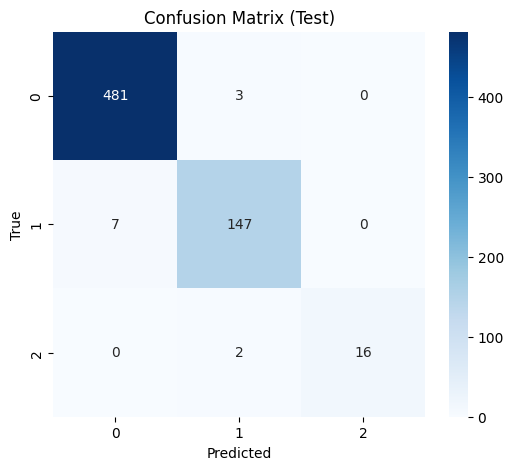

In [9]:
# =======================
#       Test 評估
# =======================
test_loss, test_acc, test_labels, test_preds = evaluate(
    model, test_loader, criterion, device
)

print("\n===== Test set 結果 =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

# 分類報告
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [12]:
import os
import json
import platform

@torch.no_grad()
def measure_inference_cnn(model, loader, device, warmup_batches=2):
    model.eval()

    # warmup
    for i, batch in enumerate(loader):
        if i >= warmup_batches:
            break
        x = batch["features"].to(device, non_blocking=True)
        lengths = batch["lengths"].to(device, non_blocking=True)
        _ = model(x, lengths)

    _sync_if_cuda(device)
    t0 = time.perf_counter()
    n = 0

    for batch in loader:
        x = batch["features"].to(device, non_blocking=True)
        lengths = batch["lengths"].to(device, non_blocking=True)
        bs = x.shape[0]
        _ = model(x, lengths)
        n += bs

    _sync_if_cuda(device)
    total_s = time.perf_counter() - t0

    ms_per_sample = (total_s / max(n, 1)) * 1000.0
    sps = n / max(total_s, 1e-12)
    return total_s, n, ms_per_sample, sps

def get_hw_sw_info(device):
    info = {
        "python_version": platform.python_version(),
        "os": platform.platform(),
        "torch_version": torch.__version__,
        "cuda_version": torch.version.cuda,
        "cudnn_version": torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None,
        "device": str(device),
    }
    if device.type == "cuda":
        info["gpu_name"] = torch.cuda.get_device_name(0)
    else:
        info["gpu_name"] = None
    return info

infer_total_s, infer_n, ms_per_sample, sps = measure_inference_cnn(model, test_loader, device)

timing = {
    "model": "CNN1D_masked_pool",
    "protocol": "A_shared_split",
    "num_parameters": int(count_params(model)),
    "epochs_ran": int(epochs_ran),
    "total_train_seconds": float(total_train_seconds),
    "avg_epoch_seconds": float(avg_epoch_seconds) if avg_epoch_seconds is not None else None,
    "batch_size": int(next(iter(test_loader))["features"].shape[0]),
    "total_infer_seconds": float(infer_total_s),
    "num_test_samples": int(infer_n),
    "ms_per_sample": float(ms_per_sample),
    "samples_per_second": float(sps),
}
timing.update(get_hw_sw_info(device))

out_dir = "/home/t113ab8043/Desktop/nanten_railway_code/runs"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "cnn1d_protocolA_timing.json")

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(timing, f, indent=2)

print(f"\n✅ Saved timing JSON: {out_path}")
print(f"Inference: {ms_per_sample:.3f} ms/sample, {sps:.2f} samples/s")



✅ Saved timing JSON: /home/t113ab8043/Desktop/nanten_railway_code/runs/cnn1d_protocolA_timing.json
Inference: 10.992 ms/sample, 90.97 samples/s


In [10]:
# =======================
#   Inference timing + JSON export (for efficiency table)
# =======================
import time
import json
import os
import numpy as np
import platform

def _sync_if_cuda(device):
    if device.type == "cuda":
        torch.cuda.synchronize()

@torch.no_grad()
def measure_inference_lstm(model, loader, device, warmup_batches=2):
    model.eval()

    # Warm-up
    for i, batch in enumerate(loader):
        if i >= warmup_batches:
            break
        x = batch["features"].to(device, non_blocking=True)
        lengths = batch["lengths"]
        _ = model(x, lengths)

    _sync_if_cuda(device)
    t0 = time.perf_counter()
    n = 0

    for batch in loader:
        x = batch["features"].to(device, non_blocking=True)
        lengths = batch["lengths"]
        bs = x.shape[0]
        _ = model(x, lengths)
        n += bs

    _sync_if_cuda(device)
    total_s = time.perf_counter() - t0

    ms_per_sample = (total_s / max(n, 1)) * 1000.0
    samples_per_s = n / max(total_s, 1e-12)
    return total_s, n, ms_per_sample, samples_per_s

# Measure inference on the shared test set
infer_total_s, infer_n, ms_per_sample, samples_per_s = measure_inference_lstm(model, test_loader, device)

# Prepare timing record
timing_record = {
    "model": "CNN_packed",
    "protocol": "A_shared_split",
    "device": str(device),
    "platform": platform.platform(),
    "python_version": platform.python_version(),
    "torch_version": torch.__version__,
    "cuda_version": torch.version.cuda,
    "cudnn_version": torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None,
    "num_parameters": int(sum(p.numel() for p in model.parameters() if p.requires_grad)),
    "epochs_ran": int(globals().get("epochs_ran", -1)),
    "total_train_seconds": float(globals().get("total_train_seconds", -1.0)),
    "avg_epoch_seconds": float(globals().get("avg_epoch_seconds", -1.0) or -1.0),
    "batch_size": int(globals().get("BATCH_SIZE", -1) if "BATCH_SIZE" in globals() else -1),
    "total_infer_seconds": float(infer_total_s),
    "num_test_samples": int(infer_n),
    "ms_per_sample": float(ms_per_sample),
    "samples_per_second": float(samples_per_s),
    "notes": "Train/val/test are shared manifests (file_path). Inference timing is model-only forward pass on test_loader."
}

OUT_JSON = "/home/t113ab8043/Desktop/nanten_railway_code/runs/cnn_protocolA_timing.json"
os.makedirs(os.path.dirname(OUT_JSON), exist_ok=True)
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(timing_record, f, indent=2)

print("✅ Saved timing JSON:", OUT_JSON)
print(f"[INFER TIMING] {ms_per_sample:.3f} ms/sample, {samples_per_s:.2f} samples/s (N={infer_n})")


✅ Saved timing JSON: /home/t113ab8043/Desktop/nanten_railway_code/runs/cnn_protocolA_timing.json
[INFER TIMING] 11.006 ms/sample, 90.86 samples/s (N=656)


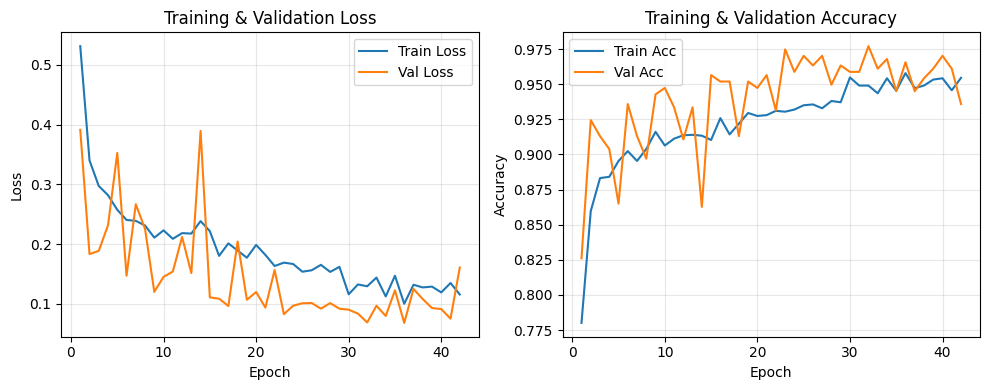

In [11]:
# =======================
#   畫 Loss Curve & Accuracy Curve
# =======================

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10, 4))

# ---- Loss curve ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(alpha=0.3)

# ---- Accuracy curve ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"],   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
